<a href="https://colab.research.google.com/github/Natali-bali/TensorFlow_Tutorial/blob/master/09_SkimLit_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SkimLit Project
We're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts. https://arxiv.org/abs/1710.06071

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.
In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

*About DataSet:*

We present PubMed 200k RCT, a new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. 

https://arxiv.org/pdf/1710.06071.pdf

There are 2 datasets, 20k and 200k

DataSet from Github https://github.com/Franck-Dernoncourt/pubmed-rct

## Prepare and explore Data

### Get helper functions

In [1]:
!wget 'https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py'

--2021-07-22 08:04:45--  https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11016 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.76K  --.-KB/s    in 0s      

2021-07-22 08:04:45 (70.3 MB/s) - ‘helper_functions.py’ saved [11016/11016]



In [2]:
import numpy as np
import re
import os
import pandas as pd
import spacy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions import plot_confusion_matrix, plot_loss_curves, classes_names, plot_pictures, create_tf_board_callback, unzip_file, compare_historys, walk_through_dir

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import  MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, GlobalAveragePooling1D, Flatten, LSTM, GRU, Bidirectional, Conv1D

### Imports

### Check GPU

In [3]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-44fa5bc6-4af3-1b44-3df9-d337794774f8)


### Download Data
We are going to use 20k dataset for first experiments

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [5]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

### Create DataBases

In [7]:
#Function to get a list of dataset name and links to files
def get_links(data_dir):
  links = [[link.replace('.txt', ''), data_dir + '/' + link] for link in os.listdir(data_dir)]
  return links

In [8]:
#Function to read data from file and return list of strings
def read_data(link):
  data_list = []
  with open(link, "r") as file:
    line = file.readlines()
    data_list.append(line)
  return data_list[0]

In [9]:
# Function to write data to DataFrame
def prepare_data(data_list):
  final_list = []
  lines_list = []
  n = 0
  for line in data_list:
    if line.startswith('###'):
      id = line.replace('\n', '').replace('###', '')
    elif line.startswith('\n'):
      for line in lines_list:
        #Add number of total lines
        line.append(len(lines_list))
        #Add number of total tokens in line
        line.append(len(line[1].split(' ')))
        #Add number of total characters in line
        line.append(len(line[1]))
        final_list.append(line)
      lines_list = []
      n = 0
    else:
      line = line.replace('\n', '')
      splited_line = line.split('\t')
      splited_line.append(id)
      splited_line.append(n)
      lines_list.append(splited_line)
      n += 1
  df = pd.DataFrame(final_list, columns = ['target', 'text', 'id', 'line_num', 'total_lines', 'tokens', 'characters'])
  return df

In [10]:
for item in get_links(data_dir):
  name = item[0]
  link = item[1]
  data_list = read_data(link)
  df = prepare_data(data_list)
  locals()['df_{0}'.format(name)] = df

In [11]:
df_test.head()

,target,text,id,line_num,total_lines,tokens,characters
0,BACKGROUND,This study analyzed liver function abnormaliti...,24845963,0,9,21,140
1,RESULTS,A post hoc analysis was conducted with the use...,24845963,1,9,28,172
2,RESULTS,Liver function tests ( LFTs ) were measured at...,24845963,2,9,25,122
3,RESULTS,Survival analyses were used to assess the asso...,24845963,3,9,59,352
4,RESULTS,The percentage of patients with abnormal LFTs ...,24845963,4,9,16,109


In [12]:
df_dev.head()

,target,text,id,line_num,total_lines,tokens,characters
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,24290286,0,10,20,134
1,BACKGROUND,It is not clear whether these patients would b...,24290286,1,10,13,80
2,OBJECTIVE,We sought to determine whether a @-month cours...,24290286,2,10,25,160
3,METHODS,Asthmatic patients who were IgE sensitized to ...,24290286,3,10,52,298
4,METHODS,Primary outcomes were improvement in quality o...,24290286,4,10,32,174


In [13]:
df_train.head()

,target,text,id,line_num,total_lines,tokens,characters
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,24293578,0,12,49,281
1,METHODS,A total of @ patients with primary knee OA wer...,24293578,1,12,27,137
2,METHODS,Outcome measures included pain reduction and i...,24293578,2,12,15,111
3,METHODS,Pain was assessed using the visual analog pain...,24293578,3,12,14,65
4,METHODS,Secondary outcome measures included the Wester...,24293578,4,12,35,209


### Explore our Dataset

In [14]:
df_total = df_dev.append(df_train, ignore_index=True).append(df_test, ignore_index = True)

[Text(0.5, 1.0, 'Distribution of total lines in each article')]

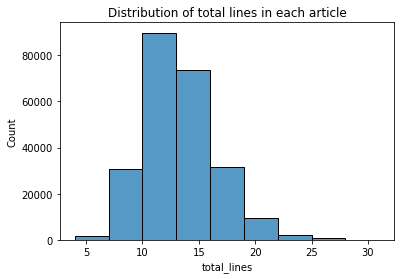

In [15]:
#Distribution of total lines in each article
sns.histplot(data=df_total, x="total_lines", binwidth=3).set(title='Distribution of total lines in each article')

In [16]:
# Number of lines of a sequence (article) covers 95% of all data?
output_line_len = int(np.percentile(df_total.total_lines.to_list(), 95))
output_line_len

19

[Text(0.5, 1.0, 'Distribution of number of tokens in each article')]

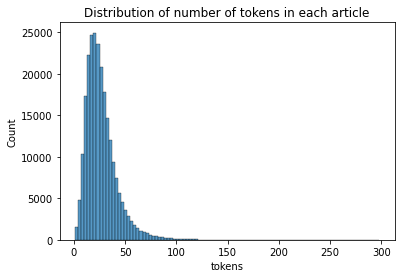

In [17]:
#Distribution of count of tokens in each line
sns.histplot(data = df_total, x="tokens", binwidth=3).set(title='Distribution of number of tokens in each article')

In [18]:
# Number of tokens of a sentence covers 95% of all data?
output_seq_len = int(np.percentile(df_total.tokens.to_list(), 95))
output_seq_len

55

[Text(0.5, 1.0, 'Distribution of number of characters in each article')]

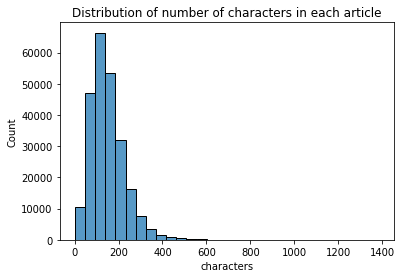

In [19]:
#Number of charcters in each line
sns.histplot(data=df_total, x="characters", bins=30).set(title='Distribution of number of characters in each article')

In [20]:
# Number of characters of a sentence covers 95% of all data?
output_char_len = int(np.percentile(df_total.characters.to_list(), 95))
output_char_len

290

In [21]:
df_train.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

### Conclusion:
We can see that our dataset is pretty balanced. We have some outliers, so we will use in our experiments maximum number which covers 95% of our data.

### Assign numerical labels

In [22]:
classes = df_train.target.unique()
classes

array(['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND'],
      dtype=object)

In [23]:
def num_classes(df):
  df['label'] = ['']*len(df)
  for cl, i in zip(classes, range(len(classes))):
    df.loc[df.target == cl, 'label'] = i
  df['label'] = df['label'].astype(int)  
  return df

In [24]:
df_dev = num_classes(df_dev)
df_test = num_classes(df_test)
df_train = num_classes(df_train)

In [25]:
df_train.head()

,target,text,id,line_num,total_lines,tokens,characters,label
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,24293578,0,12,49,281,0
1,METHODS,A total of @ patients with primary knee OA wer...,24293578,1,12,27,137,1
2,METHODS,Outcome measures included pain reduction and i...,24293578,2,12,15,111,1
3,METHODS,Pain was assessed using the visual analog pain...,24293578,3,12,14,65,1
4,METHODS,Secondary outcome measures included the Wester...,24293578,4,12,35,209,1


In [26]:
df_train.dtypes

target         object
text           object
id             object
line_num        int64
total_lines     int64
tokens          int64
characters      int64
label           int64
dtype: object

### Set up train, test and validation datasets

In [27]:
X_train = df_train['text'].tolist()
y_train = df_train['label']
X_test = df_test['text'].tolist()
y_test = df_test['label']
X_val = df_dev['text'].tolist()
y_val = df_dev['label']

### Set up One Hot Encoded labels

In [28]:
enc = OneHotEncoder(sparse=False)
y_train_one_hot =  enc.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_val_one_hot =  enc.transform(y_val.to_numpy().reshape(-1, 1))
y_test_one_hot =  enc.transform(y_test.to_numpy().reshape(-1, 1))

In [29]:
y_train_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [30]:
y_train = df_train['label'].tolist()
y_test = df_test['label'].tolist()
y_val = df_dev['label'].tolist()

In [31]:
y_test[:4]

[4, 2, 2, 2]

## Build Base models (LR and NB)

### Base Line Model Logistic Regression (LR)

In [32]:
X_train[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

In [33]:
X = X_test + X_train

In [34]:
len(X), len(X_train), len(X_test), len(y_train)

(210175, 180040, 30135, 180040)

In [35]:
y_train[:5]

[0, 1, 1, 1, 1]

In [44]:
tfid_vect = TfidfVectorizer()
X_train_tfid = tfid_vect.fit_transform(X_train)
X_test_tfid = tfid_vect.transform(X_test)

In [66]:
base_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [67]:
base_model.fit(X_train_tfid, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Save Base Model to GoggleDrive

In [40]:
filename = '/content/drive/MyDrive/projects/SPICED/models/SkimLit_base_model.sav'

In [68]:
# save the model to disk
pickle.dump(base_model, open(filename, 'wb')) 

#### Load Base Model

In [45]:
# load the model from disk
loaded_base_model = pickle.load(open(filename, 'rb'))

#### Make predictions

In [46]:
base_pred = loaded_base_model.predict(X_test_tfid)

In [47]:
base_pred[:5], y_test[:5]

(array([4, 1, 1, 1, 2]), [4, 2, 2, 2, 2])

#### Save results in DataFrame

In [48]:
df_results = pd.DataFrame(columns = ['model', 'accuracy'])

In [49]:
def save_results(model, y_test, y_pred):
  global df_results
  scores = [model, accuracy_score(y_test, y_pred)]
  df_results.loc[len(df_results)] = scores
  #79713

In [50]:
pd.DataFrame(classification_report(y_test, base_pred, output_dict = True))

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.673088,0.847249,0.853384,0.727646,0.643231,0.796781,0.748919,0.793086
recall,0.524218,0.902294,0.858128,0.697878,0.644297,0.796781,0.725363,0.796781
f1-score,0.589398,0.873905,0.855749,0.712451,0.643764,0.796781,0.735053,0.793884
support,2333.000000,9897.000000,9713.000000,4571.000000,3621.000000,0.796781,30135.000000,30135.000000


In [51]:
save_results('LR_base', y_test, base_pred)
df_results

,model,accuracy
0,LR_base,0.796781


### Naive Bayes Model

In [58]:
nb_model = MultinomialNB()

In [59]:
nb_model.fit(X_train_tfid, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [60]:
nb_pred = nb_model.predict(X_test_tfid)

In [61]:
pd.DataFrame(classification_report(y_test, nb_pred, output_dict=True))

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.742389,0.725920,0.759524,0.632556,0.645088,0.718268,0.701095,0.714151
recall,0.135877,0.877236,0.853907,0.581492,0.467827,0.718268,0.583268,0.718268
f1-score,0.229710,0.794437,0.803955,0.605950,0.542340,0.718268,0.595278,0.694902
support,2333.000000,9897.000000,9713.000000,4571.000000,3621.000000,0.718268,30135.000000,30135.000000


In [62]:
save_results('Naive_Bayers', y_test, nb_pred)
df_results

,model,accuracy
0,LR_base,0.797113
1,Naive_Bayers,0.718268


## Deep Learning Models

### 1 Model Feed-forward neural network with custom eembedding

#### Custom text vectorization and embedding

In [52]:
DIR = 'model_logs'

In [53]:
tokens = 55 #From data analyses
vocab_length = 68000 #From paper we are recreating

In [54]:
# Create TextVectorization Layer
text_vect = TextVectorization(max_tokens=vocab_length,
                              output_sequence_length = tokens)

In [55]:
text_vect.adapt(X_train)
#Try to adapt to all data X

In [56]:
# Create Embedding Layer
embedding = Embedding(input_dim = vocab_length,
                      output_dim = 128,
                      input_length = tokens)

In [83]:
X_train[1]

'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'

In [84]:
text_vect([X_train[1]])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[   8,   76,    4,   12,    7,   56,  517, 1743,    9,   29,   80,
         744,    4, 2535,    3,   80,   48,   11,   53,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [85]:
embedding(text_vect([X_train[1]]))

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.01250659, -0.04116249, -0.04211224, ...,  0.0336303 ,
          0.00846244, -0.01484295],
        [-0.00895075, -0.02208411,  0.01682368, ..., -0.01749743,
         -0.01715349, -0.00787419],
        [-0.04974806, -0.00958822, -0.04901708, ..., -0.04968099,
          0.01375442,  0.02206609],
        ...,
        [ 0.0254378 , -0.04685613,  0.02029986, ..., -0.0453117 ,
          0.03429068,  0.01931227],
        [ 0.0254378 , -0.04685613,  0.02029986, ..., -0.0453117 ,
          0.03429068,  0.01931227],
        [ 0.0254378 , -0.04685613,  0.02029986, ..., -0.0453117 ,
          0.03429068,  0.01931227]]], dtype=float32)>

#### Creating Datasets
https://www.tensorflow.org/guide/data

https://www.tensorflow.org/guide/data_performance

In [57]:
# Turn our data into TensorFlow Datasets
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val_one_hot))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))

In [58]:
# Take the TensorSliceDataset's and turn them into prefetched batches
ds_train = ds_train.batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32).prefetch(tf.data.AUTOTUNE)

ds_train

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

####Build compile fit and save model

> Indented block



In [69]:
K.clear_session()

In [ ]:
inputs = Input(shape = (1,), dtype = 'string')
x = text_vect(inputs)
x = embedding(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(classes), activation='softmax')(x)

In [ ]:
model_1 = Model(inputs, outputs)

In [ ]:
model_1.compile(optimizer='adam', metrics='accuracy', loss = 'categorical_crossentropy')

In [ ]:
model_1.summary()

In [ ]:
history_1 = model_1.fit(ds_train, epochs = 5,
                        validation_data = ds_val,
                        callbacks = create_tf_board_callback(DIR, 'model_1_base_dense'))

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1.save('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_1')

#### Load model and make predictions



In [59]:
load_model_1 = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_1')

In [60]:
load_model_1.evaluate(ds_val)

945/945 [==============================] - 6s 3ms/step - loss: 0.7175 - accuracy: 0.7838


[0.7175487875938416, 0.7837614417076111]

In [61]:
prob_1 = load_model_1.predict(X_test)

In [62]:
prob_1.shape

(30135, 5)

In [63]:
pred_1 = tf.argmax(prob_1, axis = 1)

In [64]:
pred_1[:10], y_test[:10]

(<tf.Tensor: shape=(10,), dtype=int64, numpy=array([4, 2, 1, 1, 2, 2, 2, 4, 3, 0])>,
 [4, 2, 2, 2, 2, 2, 2, 3, 3, 4])

In [65]:
save_results('model_1_128_dense',y_test, pred_1)

In [66]:
df_results

,model,accuracy
0,LR_base,0.796781
1,model_1_128_dense,0.776572


### 2 Model Conv1D with custom sequence embedding

#### Build, compile, fit and save model

In [78]:
inputs = Input(shape = (1,), dtype='string')
x = text_vect(inputs)
x = embedding(x)
x = Conv1D(64, 5, padding='same', activation='relu')(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(len(classes), activation='softmax')(x)
model_2 = Model(inputs, outputs)

In [ ]:
model_2.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [ ]:
model_2.summary()

In [ ]:
history_2 = model_2.fit(ds_train, epochs = 3,
                        steps_per_epoch = int(0.1*len(ds_train)),
                        validation_data = ds_val,
                        validation_steps = int(0.1*len(ds_val)),
                        callbacks = create_tf_board_callback(DIR, 'model_2_conv1d'))

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model_2.save('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_2')

#### Load model and make predictions

In [67]:
load_model_2 = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_2')

In [68]:
load_model_2.evaluate(ds_val)

945/945 [==============================] - 30s 4ms/step - loss: 0.6350 - accuracy: 0.7864


[0.6349807977676392, 0.7863762974739075]

In [69]:
prob_2 = load_model_2.predict(X_test)

In [70]:
pred_2 = tf.argmax(prob_2, axis = 1)

In [101]:
pred_2[10:20], y_test[10:20]

(<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 1, 1, 2, 2, 2, 2, 2, 2])>,
 [4, 1, 1, 1, 2, 2, 2, 2, 2, 2])

In [71]:
save_results('model_2_64_conv1d',y_test, pred_2)

In [72]:
df_results

,model,accuracy
0,LR_base,0.796781
1,model_1_128_dense,0.776572
2,model_2_64_conv1d,0.778264


### 3 Model USE pretrained embedding dense 128 
We will use universal-sentence-encoder


#### Build, compile, fit and save model

In [73]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133019 -0.06338634 -0.016075   ... -0.0324278  -0.0457574
   0.05370456]
 [ 0.0508086  -0.01652432  0.01573776 ...  0.0097666   0.0317012
   0.01788118]], shape=(2, 512), dtype=float32)


In [74]:
use_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                           input_shape = [],
                           dtype = tf.string,
                           trainable = False)

In [ ]:
inputs = Input(shape = [], dtype = tf.string)
x = use_layer(inputs)
x = Dense(128, activation = 'relu')(x)
outputs = Dense(len(classes), activation='softmax')(x)

In [ ]:
model_3 = Model(inputs, outputs)

In [ ]:
model_3.compile(optimizer='adam', metrics = 'accuracy', loss = 'categorical_crossentropy')

In [ ]:
model_3.summary()

In [ ]:
history_3 = model_3.fit(ds_train, epochs = 5, 
                        validation_data = ds_val,
                        validation_steps = int(0.1*len(ds_val)),
                        callbacks = create_tf_board_callback(DIR, 'model_3_use_128'))

In [ ]:
plot_loss_curves(history_3)

In [ ]:
model_3.save('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_3')

#### Load model and make predictions

In [75]:
load_model_3 = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_3')

In [76]:
prob_3 = load_model_3.predict(X_test)

In [77]:
pred_3 = tf.argmax(prob_3, axis = 1)

In [78]:
save_results('model_3_use_128',y_test, pred_3)

In [79]:
df_results

,model,accuracy
0,LR_base,0.796781
1,model_1_128_dense,0.776572
2,model_2_64_conv1d,0.778264
3,model_3_use_128,0.766517


###4 Model Conv1D with custom character embeddings

#### Prepare data
Split sentenses to characters

In [80]:
text = 'Model 4 Conv1D'

In [81]:
list(text)

['M', 'o', 'd', 'e', 'l', ' ', '4', ' ', 'C', 'o', 'n', 'v', '1', 'D']

In [82]:
# Split our text to characters
def split_to_char(text):
  return ' '.join(list(text))

In [83]:
split_to_char(text)

'M o d e l   4   C o n v 1 D'

In [84]:
X_train_char = [split_to_char(sentence) for sentence in X_train]
X_val_char = [split_to_char(sentence) for sentence in X_val]
X_test_char = [split_to_char(sentence) for sentence in X_test]

In [85]:
X_train_char[:1]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .']

In [86]:
#Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.punctuation + string.digits
print(alphabet)
len(alphabet)

abcdefghijklmnopqrstuvwxyz!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789


68

In [87]:
char_num = len(alphabet)+2

#### Custom characters vectorization and embedding

In [88]:
char_vect = TextVectorization(max_tokens = char_num, 
                              output_sequence_length = 290, #From previous analysis 95%
                              standardize = None)

In [89]:
char_vect.adapt(X_train_char)

In [90]:
char_vocab = char_vect.get_vocabulary()

In [91]:
len(char_vocab)

70

In [92]:
X_train_char[0]

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

In [93]:
char_vect([X_train_char[1]])

<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
array([[33,  3,  7,  3,  5, 11,  7, 17, 19, 14,  5,  3,  4,  2,  6,  3,
         9, 21,  4,  3, 13, 14,  8,  4, 15,  5,  8, 20, 35,  6,  2,  2,
        49, 33, 21,  2,  8,  2,  8,  5,  6, 10,  7, 15,  4, 43,  2, 10,
        19, 57, 19, 51, 19,  8,  2, 12,  2,  4, 22,  2, 10, 19, 15, 18,
        50, 10,  5, 20,  7, 17, 14,  8,  2, 10,  6,  4,  9,  7, 11,  7,
         6,  2,  5,  6, 10, 19,  8,  2, 12,  2,  4, 22,  2, 10, 14, 11,
         5, 12,  2, 23,  7, 17,  7,  8, 19, 21,  2,  2, 35,  9, 25,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

In [94]:
char_embedding = Embedding(input_dim = len(char_vocab),
                           output_dim = 25)

In [95]:
char_embedding(char_vect([X_train_char[1]]))

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[ 4.6612095e-02,  4.6899926e-02,  1.9555520e-02, ...,
          3.7848949e-05,  2.9834285e-03,  2.0509113e-02],
        [ 1.2557689e-02,  2.7835343e-02,  1.1143077e-02, ...,
         -2.0304024e-02,  5.4673441e-03,  3.4783278e-02],
        [-1.4256321e-02, -4.6135068e-02,  3.6678936e-02, ...,
         -4.4733919e-02, -1.5246354e-02, -2.4422467e-02],
        ...,
        [-1.0780655e-02, -4.6866536e-02,  4.4518400e-02, ...,
          3.0776635e-03,  4.8200820e-02, -1.9326283e-02],
        [-1.0780655e-02, -4.6866536e-02,  4.4518400e-02, ...,
          3.0776635e-03,  4.8200820e-02, -1.9326283e-02],
        [-1.0780655e-02, -4.6866536e-02,  4.4518400e-02, ...,
          3.0776635e-03,  4.8200820e-02, -1.9326283e-02]]], dtype=float32)>

#### Prepare Datasets

In [96]:
ds_train_char = tf.data.Dataset.from_tensor_slices((X_train_char, y_train_one_hot))
ds_test_char = tf.data.Dataset.from_tensor_slices((X_test_char, y_test_one_hot))
ds_val_char = tf.data.Dataset.from_tensor_slices((X_val_char, y_val_one_hot))

In [97]:
# Take the TensorSliceDataset's and turn them into prefetched batches
ds_train_char = ds_train_char.batch(32).prefetch(tf.data.AUTOTUNE)
ds_val_char = ds_val_char.batch(32).prefetch(tf.data.AUTOTUNE)
ds_test_char = ds_test_char.batch(32).prefetch(tf.data.AUTOTUNE)

ds_train_char

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

#### Build, compile, fit and save model

In [174]:
inputs = Input(shape = (1,), dtype = 'string')
x = char_vect(inputs)
x = char_embedding(x)
x = Conv1D(64, 5, padding = 'same', activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation = 'relu')(x)
outputs = Dense(len(classes), activation='softmax')(x)

In [175]:
model_4 = Model(inputs, outputs)

In [176]:
model_4.compile(optimizer='adam', metrics='accuracy', loss = 'categorical_crossentropy')

In [177]:
model_4.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_4 (TextVe (None, 290)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 290, 25)           1750      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645 

In [178]:
history_4 = model_4.fit(ds_train_char, epochs = 5,
                        validation_data = ds_val_char,
                        validation_steps = int(0.1*len(ds_val_char)),
                        callbacks = create_tf_board_callback(DIR, 'model_4_conv1d_char'))

Saving TensorBoard log files to model_logs/model_4_conv1d_char/20210721-104230
Epoch 1/5
5627/5627 [==============================] - 133s 24ms/step - loss: 1.0563 - accuracy: 0.5690 - val_loss: 0.9607 - val_accuracy: 0.6097
Epoch 2/5
5627/5627 [==============================] - 136s 24ms/step - loss: 0.9053 - accuracy: 0.6349 - val_loss: 0.8389 - val_accuracy: 0.6582
Epoch 3/5
5627/5627 [==============================] - 133s 24ms/step - loss: 0.8024 - accuracy: 0.6791 - val_loss: 0.7808 - val_accuracy: 0.6878
Epoch 4/5
5627/5627 [==============================] - 133s 24ms/step - loss: 0.7386 - accuracy: 0.7072 - val_loss: 0.7342 - val_accuracy: 0.7111
Epoch 5/5
5627/5627 [==============================] - 133s 24ms/step - loss: 0.6961 - accuracy: 0.7283 - val_loss: 0.6942 - val_accuracy: 0.7257


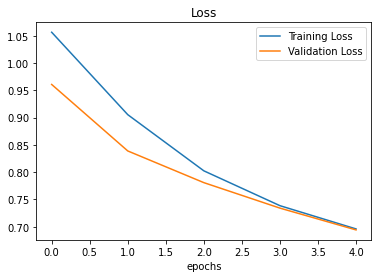

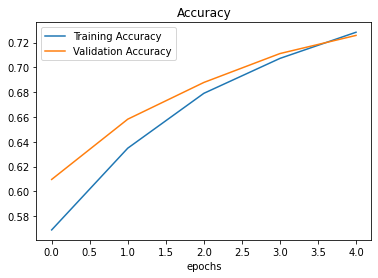

In [179]:
plot_loss_curves(history_4)

In [180]:
model_4.save('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_4')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_4/assets


#### Load model and make predictions

In [130]:
load_model_4 = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_4')

In [131]:
prob_4 = load_model_4.predict(X_test_char)

In [132]:
pred_4 = tf.argmax(prob_4, axis = 1)

In [133]:
save_results('model_4_char_conv1d',y_test, pred_4)

In [134]:
df_results

,model,accuracy
0,LR_base,0.797113
1,Naive_Bayers,0.718268
2,model_1_128_dense,0.776572
3,model_2_64_conv1d,0.778264
4,model_3_use_128,0.766517
5,model_4_char_conv1d,0.730977


### 5 Model Bi-LSTM for characters embedding

#### Build, compile , fit and save model

In [135]:
inputs = Input(shape = (1,), dtype = 'string')
x = char_vect(inputs)
x = char_embedding(x)
x = Bidirectional(LSTM(24))(x)
outputs = Dense(len(classes), activation='softmax')(x)

In [136]:
model_5 = Model(inputs, outputs)

In [137]:
model_5.compile(optimizer=tf.keras.optimizers.SGD(), metrics='accuracy', loss = 'categorical_crossentropy')

In [138]:
model_5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 290)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 290, 25)           1750      
_________________________________________________________________
bidirectional (Bidirectional (None, 48)                9600      
_________________________________________________________________
dense (Dense)                (None, 5)                 245       
Total params: 11,595
Trainable params: 11,595
Non-trainable params: 0
_________________________________________________________________


In [139]:
history_5 = model_5.fit(ds_train_char, epochs = 3,
                        steps_per_epoch = int(0.1*len(ds_train_char)),
                        validation_data = ds_val_char,
                        validation_steps = int(0.1*len(ds_val_char)),
                        callbacks = create_tf_board_callback(DIR, 'model_5_BI-LSTM_char'))

Saving TensorBoard log files to model_logs/model_5_BI-LSTM_char/20210722-073257
Epoch 1/3
562/562 [==============================] - 113s 193ms/step - loss: 1.4958 - accuracy: 0.3288 - val_loss: 1.4731 - val_accuracy: 0.3298
Epoch 2/3
562/562 [==============================] - 106s 188ms/step - loss: 1.4678 - accuracy: 0.3285 - val_loss: 1.4721 - val_accuracy: 0.3215
Epoch 3/3
562/562 [==============================] - 108s 192ms/step - loss: 1.4698 - accuracy: 0.3329 - val_loss: 1.4715 - val_accuracy: 0.3580


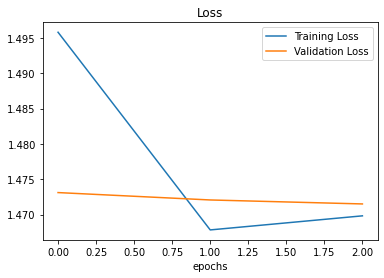

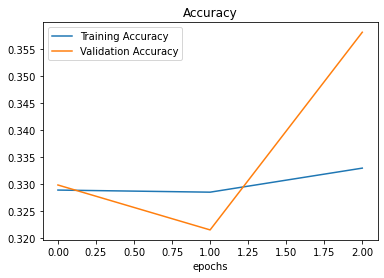

In [140]:
plot_loss_curves(history_5)

In [141]:
model_5.save('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_5/assets


#### Load model and make predictions

In [142]:
load_model_5 = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_5')

In [143]:
prob_5 = load_model_5.predict(X_test_char)

In [144]:
pred_5 = tf.argmax(prob_5, axis = 1)

In [145]:
save_results('model_5_char_bi_LSTM',y_test, pred_5)

In [146]:
df_results

,model,accuracy
0,LR_base,0.797113
1,Naive_Bayers,0.718268
2,model_1_128_dense,0.776572
3,model_2_64_conv1d,0.778264
4,model_3_use_128,0.766517
5,model_4_char_conv1d,0.730977
6,model_5_char_bi_LSTM,0.363066


### 6 Model Combining pretrained token embeddings Dense 128 + custom character embeddings Bi-LSTM (hybrid embedding layer)

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

We're going to go through the following steps:
- Create a token-level model (similar to model_2)
- Create a character-level model (similar to model_4 with a slight modification to reflect the paper) https://arxiv.org/pdf/1612.05251.pdf
- Combine (using layers.Concatenate) the outputs of 1 and 2
- Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
- Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

#### Set up tokens inputs/model

In [262]:
token_inputs = Input(shape = [], dtype = 'string', name = 'token_inputs')
x = use_layer(token_inputs)
token_outputs = Dense(128, activation = 'relu', name = 'token_outputs')(x)
token_model = Model(inputs = token_inputs, outputs = token_outputs)

In [263]:
token_model.output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'token_outputs')>

#### Set up characters inputs/model

In [264]:
char_inputs = Input(shape = (1,), dtype = 'string', name = 'char_inputs')
x = char_vect(char_inputs)
x = char_embedding(x)
char_outputs = Bidirectional(LSTM(24), name = 'char_outputs')(x)
char_model = Model(inputs = char_inputs, outputs = char_outputs)

In [265]:
char_model.output

<KerasTensor: shape=(None, 48) dtype=float32 (created by layer 'char_outputs')>

#### Concatinate both models as input

In [266]:
token_char_concat = tf.keras.layers.Concatenate(name = 'token_char_concat')([token_model.output, char_model.output])

#### Create last layers and output

In [267]:
# Create dropout layer (50% as in paper)
dropout = tf.keras.layers.Dropout(0.5, name = 'combined_dropout')(token_char_concat)
# Create Dense layer
dense = Dense(200, activation='relu', name = 'hidden_dense_layer')(dropout)
# Final Dropout
final_dropout = tf.keras.layers.Dropout(0.5, name = 'final_dropout')(dense)
# Final output
final_output = Dense(len(classes), activation='softmax', name = 'final_output')(final_dropout)

#### Build, compile and explore model

In [271]:
model_6 = Model(inputs = [token_model.input, char_model.input], outputs = final_output,
                name="model_6_token_and_char_embeddings")

In [272]:
model_6.compile(optimizer='adam', metrics = 'accuracy', loss = 'categorical_crossentropy')

In [273]:
model_6.summary()

Model: "model_6_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_4 (TextVecto (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          256797824   token_inputs[0][0]               
__________________________________________________________________

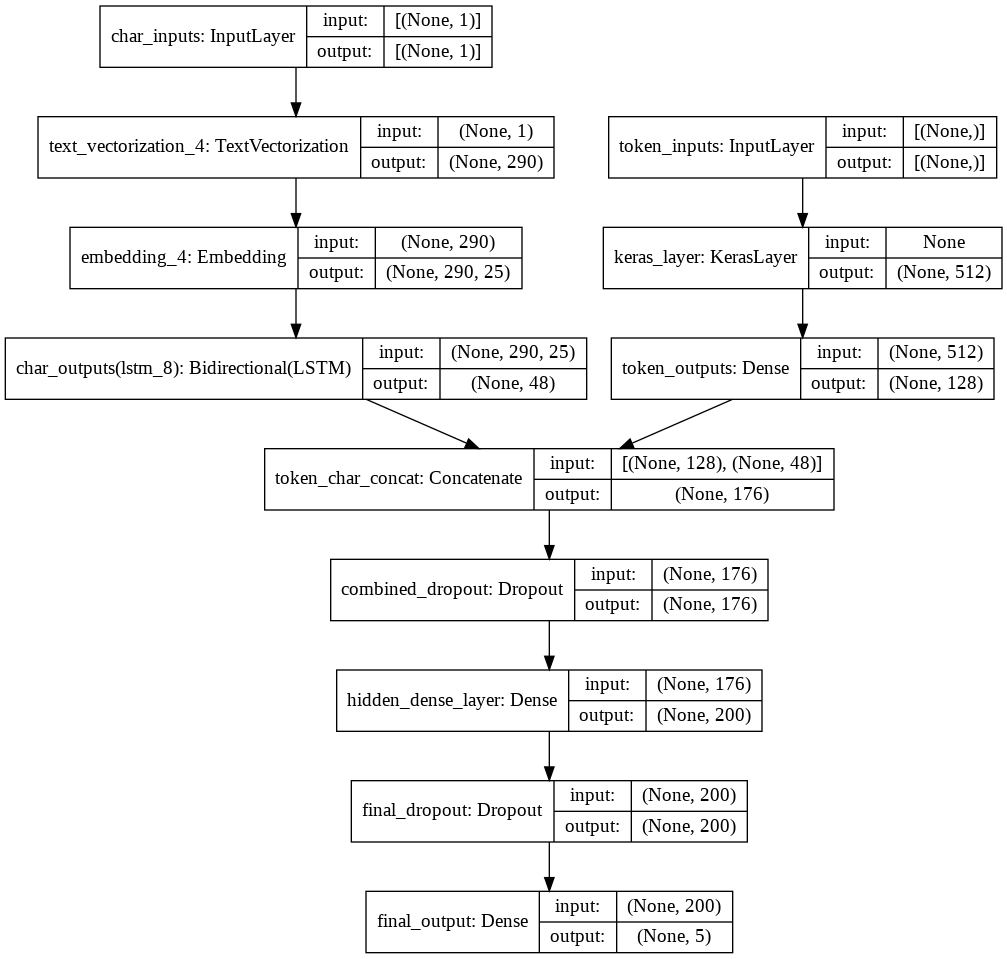

In [274]:
from tensorflow.keras.utils import plot_model
plot_model(model_6, show_shapes=True)


#### Create combined DataSets
This is important part, i need to learn it more

In [98]:
ds_train_sent_char = tf.data.Dataset.from_tensor_slices((X_train, X_train_char))
ds_train_labels = tf.data.Dataset.from_tensor_slices(y_train_one_hot)
ds_train_comb = tf.data.Dataset.zip((ds_train_sent_char, ds_train_labels))

ds_val_sent_char = tf.data.Dataset.from_tensor_slices((X_val, X_val_char))
ds_val_labels = tf.data.Dataset.from_tensor_slices(y_val_one_hot)
ds_val_comb = tf.data.Dataset.zip((ds_val_sent_char, ds_val_labels))

ds_test_sent_char = tf.data.Dataset.from_tensor_slices((X_test, X_test_char))
ds_test_labels = tf.data.Dataset.from_tensor_slices(y_test_one_hot)
ds_test_comb = tf.data.Dataset.zip((ds_test_sent_char, ds_test_labels))

ds_train_comb = ds_train_comb.batch(32).prefetch(tf.data.AUTOTUNE)
ds_val_comb = ds_val_comb.batch(32).prefetch(tf.data.AUTOTUNE)
ds_test_comb = ds_test_comb.batch(32).prefetch(tf.data.AUTOTUNE)

In [99]:
ds_train_comb

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

#### Fit and save model

In [278]:
history_6 = model_6.fit(ds_train_comb,
                        epochs = 5,
                        steps_per_epoch = int(0.1*len(ds_train_comb)),
                        validation_data = ds_val_comb,
                        validation_steps = int(0.1*len(ds_val_comb)),
                        callbacks = create_tf_board_callback(DIR, 'model_6_char_tokens'))

Saving TensorBoard log files to model_logs/model_6_char_tokens/20210721-131337
Epoch 1/5
562/562 [==============================] - 111s 198ms/step - loss: 0.9081 - accuracy: 0.6454 - val_loss: 0.7721 - val_accuracy: 0.7031
Epoch 2/5
562/562 [==============================] - 110s 196ms/step - loss: 0.7902 - accuracy: 0.6945 - val_loss: 0.7098 - val_accuracy: 0.7370
Epoch 3/5
562/562 [==============================] - 110s 196ms/step - loss: 0.7607 - accuracy: 0.7090 - val_loss: 0.6743 - val_accuracy: 0.7490
Epoch 4/5
562/562 [==============================] - 110s 195ms/step - loss: 0.7264 - accuracy: 0.7286 - val_loss: 0.6531 - val_accuracy: 0.7543
Epoch 5/5
562/562 [==============================] - 108s 192ms/step - loss: 0.7286 - accuracy: 0.7249 - val_loss: 0.6440 - val_accuracy: 0.7550


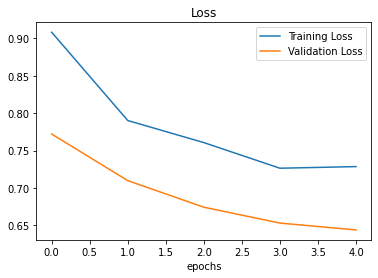

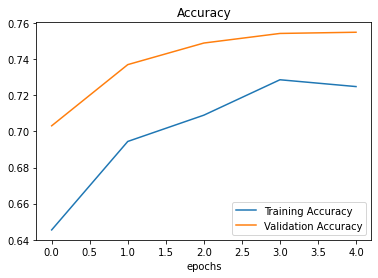

In [282]:
plot_loss_curves(history_6)

In [283]:
model_6.save('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_6')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_6/assets


#### Load model and make predictions

In [148]:
load_model_6 = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_6')

In [152]:
prob_6 = load_model_6.predict(ds_test_comb)

In [153]:
pred_6 = tf.argmax(prob_6, axis = 1)

In [154]:
save_results('model_6_char_token',y_test, pred_6)

In [155]:
df_results

,model,accuracy
0,LR_base,0.797113
1,Naive_Bayers,0.718268
2,model_1_128_dense,0.776572
3,model_2_64_conv1d,0.778264
4,model_3_use_128,0.766517
5,model_4_char_conv1d,0.730977
6,model_5_char_bi_LSTM,0.363066
7,model_6_char_token,0.747536


### 7 Model Combining custom token embeddings Conv1D (model 2) + character embeddings Conv1D (model 4)

##### Set up tokens inputs/model

In [100]:
token_inputs = Input(shape = (1,), dtype = 'string', name = 'token_inputs')
x = text_vect(token_inputs)
x = embedding(x)
x = Conv1D(64, 5, padding='same', activation='relu')(x)
x = GlobalAveragePooling1D()(x)
token_outputs = Dense(128, activation = 'relu', name = 'token_outputs')(x)
token_model = Model(inputs = token_inputs, outputs = token_outputs)

In [101]:
token_model.output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'token_outputs')>

#### Set up characters inputs/model

In [102]:
char_inputs = Input(shape = (1,), dtype = 'string', name = 'char_inputs')
x = char_vect(char_inputs)
x = char_embedding(x)
x = Conv1D(64, 5, padding = 'same', activation='relu')(x)
x = GlobalAveragePooling1D()(x)
char_outputs = Dense(128, activation = 'relu')(x)
char_model = Model(inputs = char_inputs, outputs = char_outputs)

In [103]:
char_model.output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense')>

#### Concatinate both models as input

In [104]:
token_char_concat = tf.keras.layers.Concatenate(name = 'token_char_concat')([token_model.output, char_model.output])

#### Create last layers

In [105]:
# Create dropout layer (50% as in paper)
dropout = tf.keras.layers.Dropout(0.5, name = 'combined_dropout')(token_char_concat)
# Create Dense layer
dense = Dense(200, activation='relu', name = 'hidden_dense_layer')(dropout)
# Final Dropout
final_dropout = tf.keras.layers.Dropout(0.5, name = 'final_dropout')(dense)
# Final output
final_output = Dense(len(classes), activation='softmax', name = 'final_output')(final_dropout)

#### Build, compile and explore model

In [106]:
model_7 = Model(inputs = [token_model.input, char_model.input], outputs = final_output,
                name="model_7_token_and_char_embeddings")

In [107]:
model_7.compile(optimizer='adam', metrics = 'accuracy', loss = 'categorical_crossentropy')

In [108]:
model_7.summary()

Model: "model_7_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_inputs (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 55)           0           token_inputs[0][0]               
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________

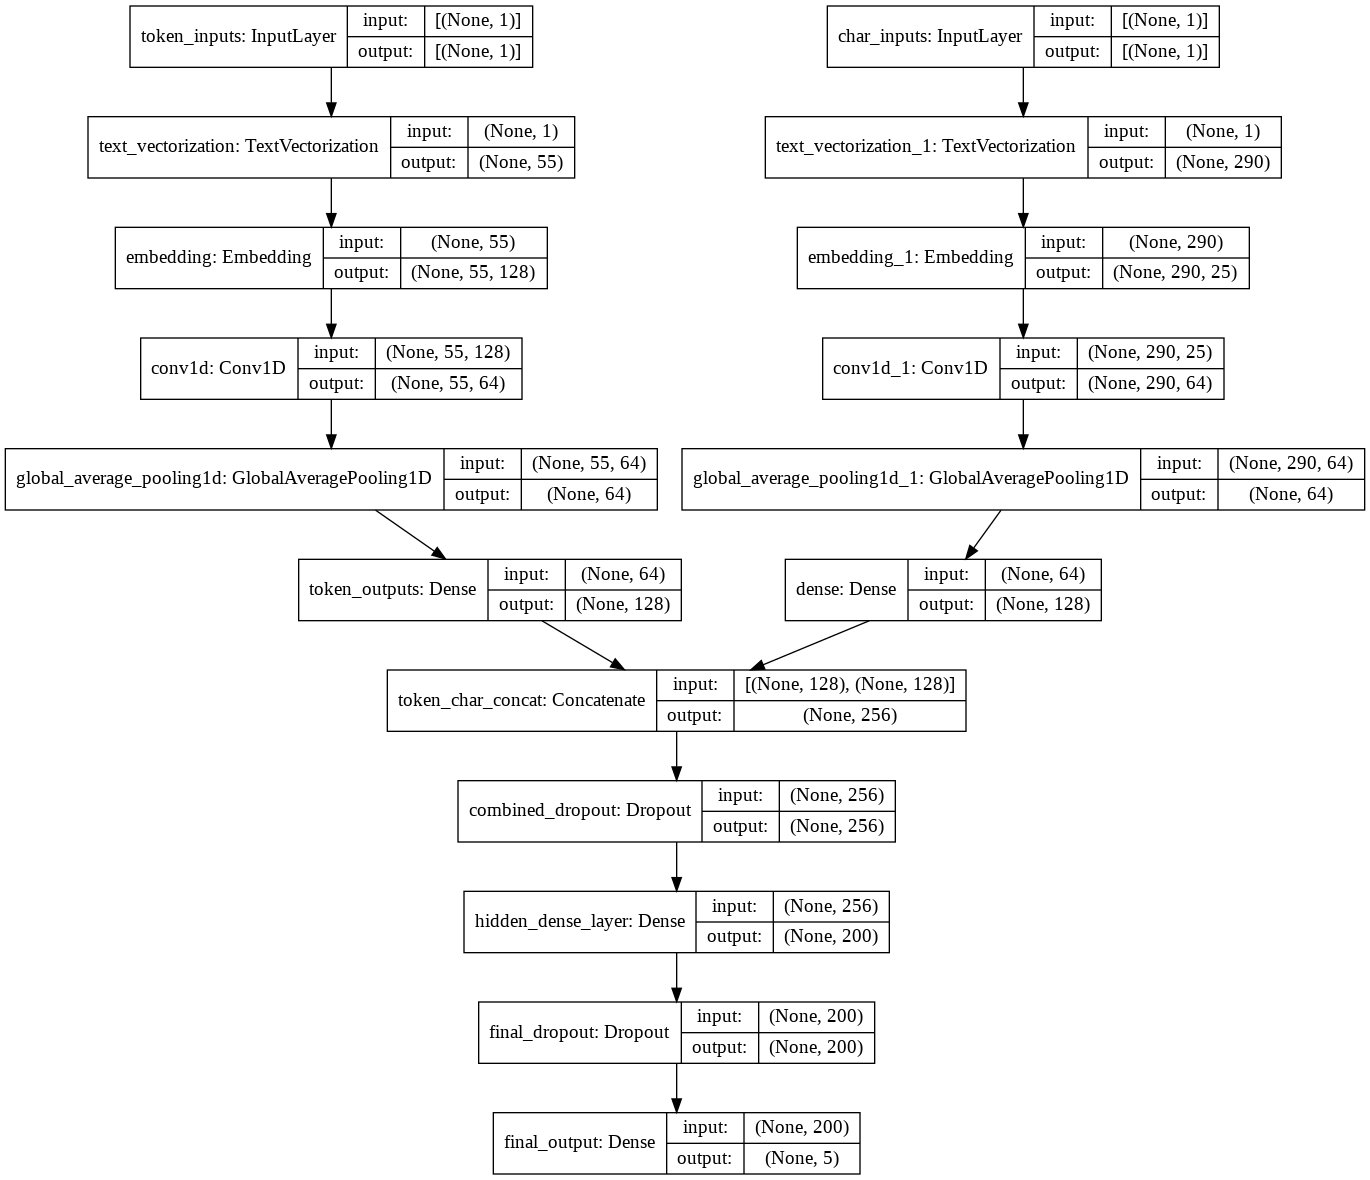

In [109]:
from tensorflow.keras.utils import plot_model
plot_model(model_7, show_shapes=True)


#### Fit and save model

In [110]:
history_7 = model_7.fit(ds_train_comb,
                        epochs = 5,
                        validation_data = ds_val_comb,
                        validation_steps = int(0.1*len(ds_val_comb)),
                        callbacks = create_tf_board_callback(DIR, 'model_7_char_tokens'))

Saving TensorBoard log files to model_logs/model_7_char_tokens/20210722-081330
Epoch 1/5
5627/5627 [==============================] - 499s 88ms/step - loss: 0.6186 - accuracy: 0.7655 - val_loss: 0.4934 - val_accuracy: 0.8135
Epoch 2/5
5627/5627 [==============================] - 495s 88ms/step - loss: 0.4380 - accuracy: 0.8453 - val_loss: 0.4857 - val_accuracy: 0.8231
Epoch 3/5
5627/5627 [==============================] - 491s 87ms/step - loss: 0.3477 - accuracy: 0.8793 - val_loss: 0.5387 - val_accuracy: 0.8218
Epoch 4/5
5627/5627 [==============================] - 489s 87ms/step - loss: 0.2730 - accuracy: 0.9073 - val_loss: 0.6606 - val_accuracy: 0.8102
Epoch 5/5
5627/5627 [==============================] - 488s 87ms/step - loss: 0.2186 - accuracy: 0.9269 - val_loss: 0.7308 - val_accuracy: 0.7995


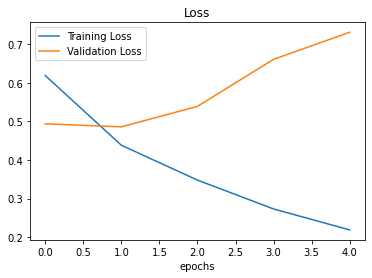

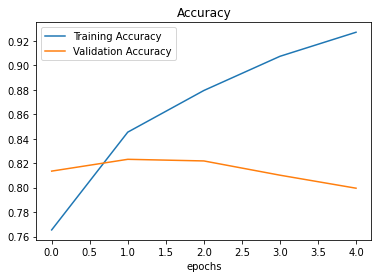

In [111]:
plot_loss_curves(history_7)

In [114]:
model_7.save('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_7_3')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_7_3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_7_3/assets


#### Load model and make predictions

In [115]:
load_model_7 = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_7_3')

In [116]:
prob_7 = load_model_7.predict(ds_test_comb)

In [117]:
pred_7 = tf.argmax(prob_7, axis = 1)

In [118]:
pd.DataFrame(classification_report(y_test, pred_7, output_dict = True))


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.604706,0.865206,0.861649,0.750646,0.609769,0.797578,0.738395,0.795822
recall,0.550793,0.893705,0.866262,0.698753,0.634355,0.797578,0.728774,0.797578
f1-score,0.576492,0.879225,0.863949,0.723771,0.621819,0.797578,0.733051,0.796354
support,2333.000000,9897.000000,9713.000000,4571.000000,3621.000000,0.797578,30135.000000,30135.000000


In [119]:
save_results('model_7_char_token',y_test, pred_7)

In [120]:
df_results

,model,accuracy
0,LR_base,0.796781
1,model_1_128_dense,0.776572
2,model_2_64_conv1d,0.778264
3,model_3_use_128,0.766517
4,model_7_char_token,0.797578
